In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import orekit

In [2]:
from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime, datetime_to_absolutedate
from org.orekit.utils import ExtendedPVCoordinatesProvider
from org.orekit.orbits import OrbitType, KeplerianOrbit, EquinoctialOrbit, PositionAngle
from org.orekit.propagation.semianalytical.dsst import DSSTPropagator
from org.orekit.propagation import PropagationType
from org.orekit.propagation.semianalytical.dsst.forces import DSSTZonal, DSSTTesseral
from org.orekit.propagation import SpacecraftState
from org.orekit.frames import FramesFactory
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.forces.gravity.potential import GravityFieldFactory
from orekit import JArray_double
from org.orekit.bodies import CelestialBodyFactory, CelestialBody,OneAxisEllipsoid
from org.orekit.utils import IERSConventions
from org.orekit.utils import Constants

In [3]:
from org.orekit.forces import BoxAndSolarArraySpacecraft
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel, ThirdBodyAttraction
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.drag import IsotropicDrag, DragForce
from org.orekit.forces.radiation import IsotropicRadiationClassicalConvention, SolarRadiationPressure
from org.orekit.models.earth.atmosphere import HarrisPriester

In [4]:
vm = orekit.initVM()
setup_orekit_curdir("../../../orekit-data.zip")

In [5]:
# simulation times
from datetime import timezone
t_start = datetime.datetime(2024, 1, 1, 12, tzinfo=timezone.utc)
duration = 5 * 365 * 24 * 60 * 60
t_end = t_start + datetime.timedelta(seconds=duration)
step_size = 24*60*60
# orekit times
t_start_ok = datetime_to_absolutedate(t_start)
t_end_ok = datetime_to_absolutedate(t_end)

In [6]:
time_vec_orekit = [t_start_ok.shiftedBy(float(dt)) for dt in np.arange(0, duration, step_size)]


In [7]:
inertial_frame = FramesFactory.getEME2000()

In [8]:
earth_frame = FramesFactory.getITRF(IERSConventions.IERS_2010, True)

In [9]:
# earth position velocity object
earth = CelestialBodyFactory.getEarth()
earth_pv = ExtendedPVCoordinatesProvider.cast_(earth)

# earth shape: an ellipsoid
earth_shape = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                               Constants.WGS84_EARTH_FLATTENING, earth_frame)


In [10]:
sun =  CelestialBodyFactory.getSun()

In [11]:
hrs_from_noon = 9

In [12]:
sun_pv = ExtendedPVCoordinatesProvider.cast_(sun)

In [13]:
sun_coordinates = sun_pv.getPVCoordinates(t_start_ok, inertial_frame)
sun_position = np.array([
    sun_coordinates.getPosition().getX(),
    sun_coordinates.getPosition().getY(),
    sun_coordinates.getPosition().getZ()
])
theta_sun = np.arctan2(sun_position[1], sun_position[0])
raan = theta_sun + hrs_from_noon * 2 * np.pi / 24.0

In [14]:
np.rad2deg(theta_sun - raan)

-135.0

In [15]:
np.rad2deg(raan)

56.11747603956352

In [16]:
# a = earth_shape.getEquatorialRadius() + 567e3
# i = np.deg2rad(97.7)
# w = 0
# e = 0
a = 6978.137e3
e = 0.0012
i = np.deg2rad(97.82)
w = np.pi/2
raan = np.deg2rad(59.38)

In [17]:
initial_state = SpacecraftState(
EquinoctialOrbit(float(a), float(e * np.cos(w + raan)),
                    float(e * np.sin(w + raan)),
                    float(np.tan(i / 2) * np.cos(raan)),
                    float(np.tan(i / 2) * np.sin(raan)), float(0 + w + raan),
                    PositionAngle.MEAN, inertial_frame,
                    t_start_ok, earth.getGM()),
float(200.0))



In [18]:
from org.hipparchus.geometry.euclidean.threed import Vector3D

In [19]:
physical_sc = BoxAndSolarArraySpacecraft(float(0.58), float(0.45),
                                                   float(0.41), sun,
                                                   float(1.5 * 1.6),
                                                   Vector3D(float(0.0), float(0.83867), float(-0.54463904)),
                                                   t_start_ok,
                                                   Vector3D.PLUS_I,
                                                   float(0.0), float(2.2),
                                                   float(0.5), float(0.5))


In [20]:
from org.orekit.propagation.semianalytical.dsst.forces import DSSTAtmosphericDrag
from org.orekit.forces.gravity import ThirdBodyAttraction as OrekitThirdBodyAttraction
from org.orekit.propagation.semianalytical.dsst.forces import DSSTThirdBody
from org.orekit.forces.radiation import SolarRadiationPressure
from org.orekit.propagation.semianalytical.dsst.forces import DSSTSolarRadiationPressure

In [21]:
solar_3b_perturbations = DSSTThirdBody(sun, earth.getGM())


In [22]:
lunar_3b_perturbations = DSSTThirdBody(CelestialBodyFactory.getMoon(), earth.getGM())

In [23]:
drag_force = DSSTAtmosphericDrag(HarrisPriester(sun, earth_shape, float(4.0)), physical_sc, earth.getGM())


In [24]:
srp_force= DSSTSolarRadiationPressure(sun, earth_shape.getEquatorialRadius(), physical_sc, earth.getGM())

In [29]:
min_step = float(86400.0)
max_step = float(86400.0)
position_tolerance = float(1.0)
orbit_type = OrbitType.EQUINOCTIAL
tolerances = DSSTPropagator.tolerances(position_tolerance, float(1e-3),
                                        initial_state.getOrbit())
integrator = DormandPrince853Integrator(min_step, max_step,
                                        JArray_double.cast_(tolerances[0]),
                                        JArray_double.cast_(tolerances[1]))
propagator = DSSTPropagator(integrator, PropagationType.MEAN)
zonal_force = DSSTZonal(GravityFieldFactory.getUnnormalizedProvider(36, 36))
tesseral_force = DSSTTesseral(earth_frame, float(2*np.pi/86400), GravityFieldFactory.getUnnormalizedProvider(21, 21))


In [30]:
propagator.addForceModel(zonal_force)
propagator.addForceModel(drag_force)
propagator.addForceModel(srp_force)
propagator.addForceModel(solar_3b_perturbations)
propagator.addForceModel(lunar_3b_perturbations)

In [31]:
propagator.setInitialState(initial_state, PropagationType.MEAN)
sc_data = [propagator.propagate(t) for t in time_vec_orekit]
sma_propagated = [s.getA() / 1e3 for s in sc_data]
i_propagated = [s.getI() for s in sc_data]
e_propagated = []
w_propagated = []
raan_propagated = []
mean_anomaly_propagated = []
for state in sc_data:
    keplerian = KeplerianOrbit.cast_(
        OrbitType.KEPLERIAN.convertType(state.getOrbit()))
    e_propagated.append(keplerian.getE())
    w_propagated.append(keplerian.getPerigeeArgument())
    raan_propagated.append(keplerian.getRightAscensionOfAscendingNode())
    mean_anomaly_propagated.append(keplerian.getAnomaly(PositionAngle.MEAN))

In [32]:
sun_coordinates = [sun_pv.getPVCoordinates(t, inertial_frame) for t in time_vec_orekit]

In [33]:
sun_positions = np.array([[c.getPosition().getX(), c.getPosition().getY(), c.getPosition().getZ()] for c in sun_coordinates])

In [34]:
sun_positions.shape

(1825, 3)

In [35]:
from mpl_toolkits.mplot3d import Axes3D

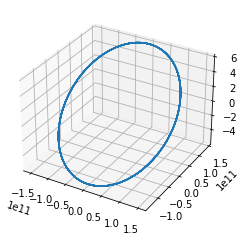

In [36]:
f_sun = plt.figure("Sun")
ax_sun_3d = f_sun.add_subplot(projection='3d')
ax_sun_3d.plot(sun_positions[:, 0], sun_positions[:, 1], sun_positions[:, 2])

In [37]:
np.rad2deg(np.arctan2(sun_positions[0, 1], sun_positions[0, 0]))

-78.88252396043649

In [38]:
thetas_sun = np.arctan2(sun_positions[:, 1], sun_positions[:, 0])

In [39]:
thetas_sun = np.array([theta-2*np.pi if theta>np.pi else theta for theta in thetas_sun ])

In [40]:
ltan_all = thetas_sun - np.array(raan_propagated) if thetas_sun[0] > raan_propagated[0] else np.array(raan_propagated) - thetas_sun 


In [41]:
ltan_all = np.array([2*np.pi + ltan  if ltan < 0 else ltan for ltan in ltan_all])

In [42]:
np.rad2deg(thetas_sun[0] - raan_propagated[0])

-138.2625239604365

In [43]:
thetas_sun[0]

-1.3767597653929338

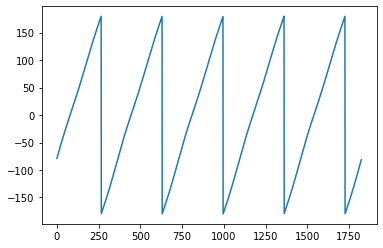

In [44]:
plt.plot(np.rad2deg(thetas_sun))

In [45]:
np.rad2deg(thetas_sun[0])

-78.88252396043649

In [46]:
np.rad2deg(raan_propagated[0])

59.380000000000024

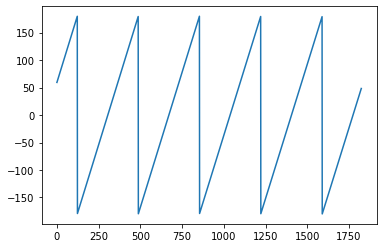

In [47]:
plt.plot(np.rad2deg(raan_propagated))

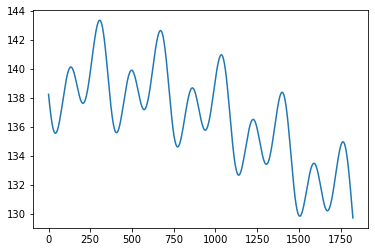

In [48]:
plt.plot(np.rad2deg(ltan_all))

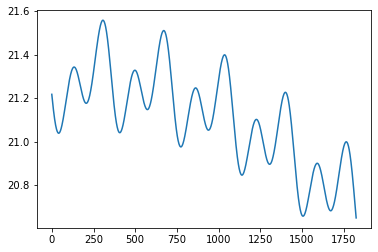

In [49]:
plt.plot(12 + np.rad2deg(ltan_all)*(24/360))

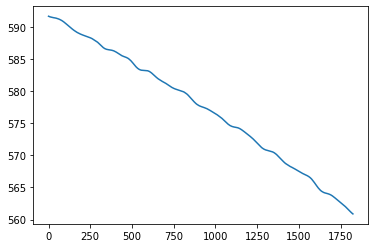

In [54]:
plt.plot(np.multiply(np.array(sma_propagated), (1 - np.array(e_propagated))) - earth_shape.getEquatorialRadius()/1e3)

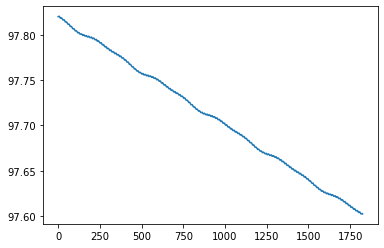

In [55]:
plt.plot(np.rad2deg(i_propagated))